In [1]:
# For array, dataset, and visualizing
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

sns.set_style("whitegrid")
np.random.seed(0)

In [2]:
df = pd.read_csv('balanced_trad.csv')
df.head()

,t,l
0,why have i not got my new card?,11
1,Can you tell me if I can track the card you se...,11
2,How long will it take for me to get my card?,11
3,How long does it take for my new card to arriv...,11
4,Could I get tracking on the card?,11


In [3]:
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42, shuffle=True)

In [4]:
#For Pre-Processing
from tqdm import tqdm
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
nltk.download('punkt')
from nltk.tokenize import RegexpTokenizer 
from nltk.tokenize import word_tokenize
import codecs


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [5]:
MAX_NB_WORDS = 100000
tokenizer = RegexpTokenizer(r'\w+')
stop_words = set(stopwords.words('english'))
stop_words.update(['.', ',', '"', "'", ':', ';', '(', ')', '[', ']', '{', '}'])

In [6]:
label_names = ["l"]
y_train = train_df[label_names].values
train_df['doc_len'] = train_df['t'].apply(lambda words: len(words.split(" ")))
max_seq_len = np.round(train_df['doc_len'].mean() + train_df['doc_len'].std()).astype(int)


In [7]:
from sklearn.utils import shuffle 
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence

raw_docs_train = train_df['t'].tolist()
raw_docs_test = test_df['t'].tolist() 
num_classes = len(label_names)

print("pre-processing train data...")

processed_docs_train = []
for doc in tqdm(raw_docs_train):
    tokens = word_tokenize(doc)
    filtered = [word for word in tokens if word not in stop_words]
    processed_docs_train.append(" ".join(filtered))
#end for

processed_docs_test = []
for doc in tqdm(raw_docs_test):
    tokens = word_tokenize(doc)
    filtered = [word for word in tokens if word not in stop_words]
    processed_docs_test.append(" ".join(filtered))
#end for

print("tokenizing input data...")
tokenizer = Tokenizer(num_words=MAX_NB_WORDS, lower=True, char_level=False)
tokenizer.fit_on_texts(processed_docs_train + processed_docs_test)  #leaky
word_seq_train = tokenizer.texts_to_sequences(processed_docs_train)
word_seq_test = tokenizer.texts_to_sequences(processed_docs_test)
word_index = tokenizer.word_index
print("dictionary size: ", len(word_index))

#pad sequences
word_seq_train = sequence.pad_sequences(word_seq_train, maxlen=max_seq_len)
word_seq_test = sequence.pad_sequences(word_seq_test, maxlen=max_seq_len)

pre-processing train data...


100%|██████████| 2662/2662 [00:00<00:00, 3197.94it/s]


tokenizing input data...
dictionary size:  2521


## Fastext


In [8]:
import requests, zipfile, io
zip_file_url = "https://dl.fbaipublicfiles.com/fasttext/vectors-english/crawl-300d-2M.vec.zip"
r = requests.get(zip_file_url)
z = zipfile.ZipFile(io.BytesIO(r.content))
z.extractall()

In [9]:
embeddings_index = {}
f = codecs.open('crawl-300d-2M.vec', encoding='utf-8')

for line in tqdm(f):
    values = line.rstrip().rsplit(' ')
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('found %s word vectors' % len(embeddings_index))

1999996it [02:41, 12359.02it/s]

found 1999996 word vectors


### LSTM

In [10]:
# For Training
import keras
from keras import optimizers
from keras import backend as K
from keras import regularizers
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout, Flatten
from keras.layers import Embedding, Conv1D, MaxPooling1D, GlobalMaxPooling1D
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
# from keras.utils import plot_model
from keras.preprocessing import sequence
from keras.callbacks import EarlyStopping

#training params
batch_size = 256 
num_epochs = 40

#model parameters
num_filters = 64 
embed_dim = 300 
weight_decay = 1e-4

In [11]:
#embedding matrix

words_not_found = []
nb_words = min(MAX_NB_WORDS, len(word_index)+1)
embedding_matrix = np.zeros((nb_words, embed_dim))

for word, i in word_index.items():
    if i >= nb_words:
        continue
    embedding_vector = embeddings_index.get(word)
    if (embedding_vector is not None) and len(embedding_vector) > 0:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector
    else:
        words_not_found.append(word)
print('number of null word embeddings: %d' % np.sum(np.sum(embedding_matrix, axis=1) == 0))

number of null word embeddings: 49


In [12]:
print("sample words not found: ", np.random.choice(words_not_found, 10))

sample words not found:  ['moeney' 'refurn' "n't" '£1' '£1' "c'mon" 'interbanks' 'revieve'
 'courtries' 'cryto']


In [13]:
from keras.layers import BatchNormalization
import tensorflow as tf

def create_lstm_model():
  model_lstm = tf.keras.Sequential()
  model_lstm.add(Embedding(nb_words,embed_dim,input_length=max_seq_len, weights=[embedding_matrix],trainable=False))
  # model.add(SpatialDropout1D(0.7))
  model_lstm.add(Bidirectional(LSTM(128, dropout=0.7, recurrent_dropout=0.7)))
  model_lstm.add(Dense(128,activation='relu'))
  model_lstm.add(Dense(77, activation='softmax'))
  model_lstm.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])
  return model_lstm


In [14]:
model_lstm_ft = create_lstm_model()
model_lstm_ft.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 19, 300)           756600    
                                                                 
 bidirectional (Bidirectiona  (None, 256)              439296    
 l)                                                              
                                                                 
 dense (Dense)               (None, 128)               32896     
                                                                 
 dense_1 (Dense)             (None, 77)                9933      
                                                                 
Total params: 1,238,725
Trainable params: 482,125
Non-trainable params: 756,600
_________________________________________________________________


In [15]:
# from keras.optimizers import RMSprop
from keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import EarlyStopping

# model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model_lstm_ft.compile(optimizer='adam',loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])

In [16]:
es_callback = EarlyStopping(monitor='val_loss', patience=3)

history = model_lstm_ft.fit(word_seq_train, y_train, batch_size=256, epochs=num_epochs, validation_split=0.3, callbacks=[es_callback], shuffle=False)



Epoch 1/40


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


30/30 [==============================] - 12s 179ms/step - loss: 4.2458 - accuracy: 0.0616 - val_loss: 3.9338 - val_accuracy: 0.1800
Epoch 2/40
30/30 [==============================] - 5s 163ms/step - loss: 3.4275 - accuracy: 0.2108 - val_loss: 2.4741 - val_accuracy: 0.3787
Epoch 3/40
30/30 [==============================] - 5s 166ms/step - loss: 2.3721 - accuracy: 0.3948 - val_loss: 1.5908 - val_accuracy: 0.5793
Epoch 4/40
30/30 [==============================] - 5s 168ms/step - loss: 1.8673 - accuracy: 0.4883 - val_loss: 1.2556 - val_accuracy: 0.6557
Epoch 5/40
30/30 [==============================] - 5s 172ms/step - loss: 1.5629 - accuracy: 0.5722 - val_loss: 1.0675 - val_accuracy: 0.7070
Epoch 6/40
30/30 [==============================] - 5s 167ms/step - loss: 1.3818 - accuracy: 0.6095 - val_loss: 0.9491 - val_accuracy: 0.7393
Epoch 7/40
30/30 [==============================] - 5s 162ms/step - loss: 1.2529 - accuracy: 0.6445 - val_loss: 0.8745 - val_accuracy: 0.7571
Epoch 8/40
30/30

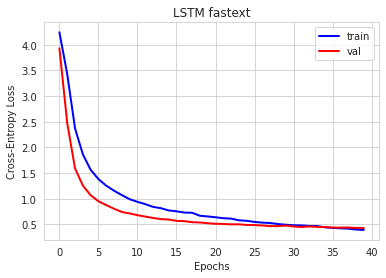

In [17]:
#generate plots
plt.figure()
plt.plot(history.history['loss'], lw=2.0, color='b', label='train')
plt.plot(history.history['val_loss'], lw=2.0, color='r', label='val')
plt.title('LSTM fastext')
plt.xlabel('Epochs')
plt.ylabel('Cross-Entropy Loss')
plt.legend(loc='upper right')
plt.show()

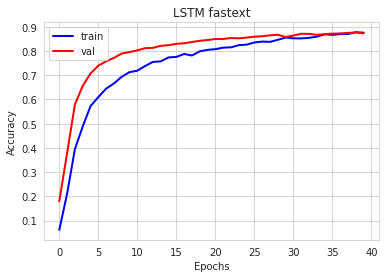

In [18]:
plt.figure()
plt.plot(history.history['accuracy'], lw=2.0, color='b', label='train')
plt.plot(history.history['val_accuracy'], lw=2.0, color='r', label='val')
plt.title('LSTM fastext')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='upper left')
plt.show()

In [19]:
predictions = model_lstm_ft.predict(word_seq_test)
list_ = []
for i in range(len(predictions)):
  a = predictions[i]
  list_.append(np.where(a == a.max())[0][0] )


sample= test_df
sample['pred']= list_ 
sample[['pred', "l"]]

,pred,l
6113,22,22
2453,23,23
2442,49,49
2859,52,47
12994,69,69
...,...,...
7532,27,27
3434,57,15
694,17,17
5168,68,68


In [20]:
import sklearn

print("Accuracy With fastText LSTM:")
print(sklearn.metrics.accuracy_score(sample.l, sample.pred))

Accuracy With fastText LSTM:
0.864763335837716


### CNN

In [21]:
num_filters = 64 

In [22]:
#CNN architecture
def create_cnn_model():
  model_cnn = Sequential()
  model_cnn.add(Embedding(nb_words, embed_dim, weights=[embedding_matrix], input_length=max_seq_len, trainable=False))
  model_cnn.add(Conv1D(num_filters, 7, activation='relu', padding='same'))
  model_cnn.add(MaxPooling1D(2))
  model_cnn.add(Conv1D(num_filters, 7, activation='relu', padding='same'))
  model_cnn.add(GlobalMaxPooling1D())
  model_cnn.add(Dropout(0.5))
  model_cnn.add(Dense(32, activation='relu', kernel_regularizer=regularizers.l2(weight_decay)))
  model_cnn.add(Dense(77, activation='softmax'))

  adam = tf.keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
  model_cnn.compile(loss='binary_crossentropy', optimizer=adam, metrics=['accuracy'])
  return model_cnn


In [23]:
model_cnn_ft = create_cnn_model()  
model_cnn_ft.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 19, 300)           756600    
                                                                 
 conv1d (Conv1D)             (None, 19, 64)            134464    
                                                                 
 max_pooling1d (MaxPooling1D  (None, 9, 64)            0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 9, 64)             28736     
                                                                 
 global_max_pooling1d (Globa  (None, 64)               0         
 lMaxPooling1D)                                                  
                                                                 
 dropout (Dropout)           (None, 64)               

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [24]:
from keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import EarlyStopping

model_cnn_ft.compile(optimizer='adam',loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])

In [25]:
es_callback = EarlyStopping(monitor='val_loss', patience=3)

history = model_cnn_ft.fit(word_seq_train, y_train, batch_size=256, epochs=num_epochs, validation_split=0.3, callbacks=[es_callback], shuffle=False)

Epoch 1/40


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


30/30 [==============================] - 10s 18ms/step - loss: 4.3232 - accuracy: 0.0205 - val_loss: 4.2450 - val_accuracy: 0.0369
Epoch 2/40
30/30 [==============================] - 0s 8ms/step - loss: 4.1163 - accuracy: 0.0448 - val_loss: 3.8170 - val_accuracy: 0.1058
Epoch 3/40
30/30 [==============================] - 0s 8ms/step - loss: 3.5988 - accuracy: 0.1299 - val_loss: 3.1011 - val_accuracy: 0.2513
Epoch 4/40
30/30 [==============================] - 0s 8ms/step - loss: 2.9246 - accuracy: 0.2472 - val_loss: 2.3105 - val_accuracy: 0.4444
Epoch 5/40
30/30 [==============================] - 0s 7ms/step - loss: 2.3863 - accuracy: 0.3563 - val_loss: 1.8035 - val_accuracy: 0.5637
Epoch 6/40
30/30 [==============================] - 0s 7ms/step - loss: 2.0120 - accuracy: 0.4345 - val_loss: 1.5025 - val_accuracy: 0.6254
Epoch 7/40
30/30 [==============================] - 0s 8ms/step - loss: 1.7516 - accuracy: 0.5008 - val_loss: 1.3130 - val_accuracy: 0.6761
Epoch 8/40
30/30 [===========

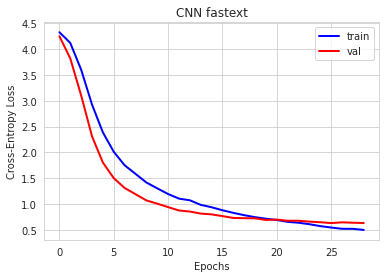

In [26]:
#generate plots
plt.figure()
plt.plot(history.history['loss'], lw=2.0, color='b', label='train')
plt.plot(history.history['val_loss'], lw=2.0, color='r', label='val')
plt.title('CNN fastext')
plt.xlabel('Epochs')
plt.ylabel('Cross-Entropy Loss')
plt.legend(loc='upper right')
plt.show()

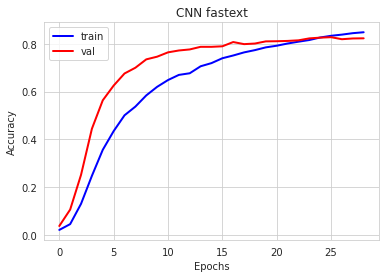

In [27]:
plt.figure()
plt.plot(history.history['accuracy'], lw=2.0, color='b', label='train')
plt.plot(history.history['val_accuracy'], lw=2.0, color='r', label='val')
plt.title('CNN fastext')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='upper left')
plt.show()

In [28]:
predictions = model_cnn_ft.predict(word_seq_test)
list_ = []
for i in range(len(predictions)):
  a = predictions[i]
  list_.append(np.where(a == a.max())[0][0] )


sample= test_df
sample['pred']= list_ 
sample[['pred', "l"]]

,pred,l
6113,22,22
2453,23,23
2442,49,49
2859,66,47
12994,69,69
...,...,...
7532,27,27
3434,57,15
694,17,17
5168,68,68


In [29]:
import sklearn

print("Accuracy With fastText CNN :")
print(sklearn.metrics.accuracy_score(sample.l, sample.pred))

Accuracy With fastText CNN :
0.816679188580015


### CNN + LSTM

In [30]:
def create_cnn_lstm_model():
  model_mix = Sequential()
  model_mix.add(Embedding(nb_words, embed_dim, weights=[embedding_matrix], input_length=max_seq_len, trainable=False))
  model_mix.add(Dropout(0.2))
  model_mix.add(Conv1D(num_filters, 7, activation='relu', padding='same'))
  model_mix.add(MaxPooling1D(pool_size=4))
  model_mix.add(Bidirectional(LSTM(128, dropout=0.7, recurrent_dropout=0.7)))
  model_mix.add(Dense(128,activation='relu'))
  model_mix.add(Dense(77, activation='softmax'))
  model_mix.compile(optimizer='adam',loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])
  return model_mix


In [31]:
model_mix_ft = create_cnn_lstm_model()

In [32]:
es_callback = EarlyStopping(monitor='val_loss', patience=3)

history = model_mix_ft.fit(word_seq_train, y_train, batch_size=256, epochs=num_epochs, validation_split=0.3, callbacks=[es_callback], shuffle=False)

Epoch 1/40


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


30/30 [==============================] - 6s 65ms/step - loss: 4.3228 - accuracy: 0.0174 - val_loss: 4.2667 - val_accuracy: 0.0203
Epoch 2/40
30/30 [==============================] - 1s 50ms/step - loss: 4.1333 - accuracy: 0.0627 - val_loss: 3.7372 - val_accuracy: 0.1408
Epoch 3/40
30/30 [==============================] - 1s 49ms/step - loss: 3.4157 - accuracy: 0.1524 - val_loss: 2.6024 - val_accuracy: 0.3105
Epoch 4/40
30/30 [==============================] - 1s 48ms/step - loss: 2.6558 - accuracy: 0.2680 - val_loss: 1.9626 - val_accuracy: 0.4623
Epoch 5/40
30/30 [==============================] - 1s 50ms/step - loss: 2.1771 - accuracy: 0.3697 - val_loss: 1.6139 - val_accuracy: 0.5380
Epoch 6/40
30/30 [==============================] - 2s 50ms/step - loss: 1.8932 - accuracy: 0.4352 - val_loss: 1.3709 - val_accuracy: 0.6100
Epoch 7/40
30/30 [==============================] - 2s 54ms/step - loss: 1.6907 - accuracy: 0.4875 - val_loss: 1.2154 - val_accuracy: 0.6535
Epoch 8/40
30/30 [======

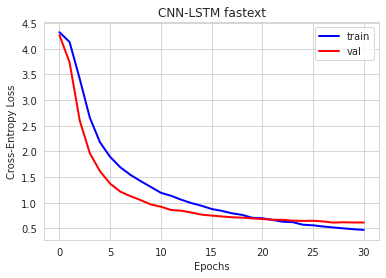

In [33]:
#generate plots
plt.figure()
plt.plot(history.history['loss'], lw=2.0, color='b', label='train')
plt.plot(history.history['val_loss'], lw=2.0, color='r', label='val')
plt.title('CNN-LSTM fastext')
plt.xlabel('Epochs')
plt.ylabel('Cross-Entropy Loss')
plt.legend(loc='upper right')
plt.show()

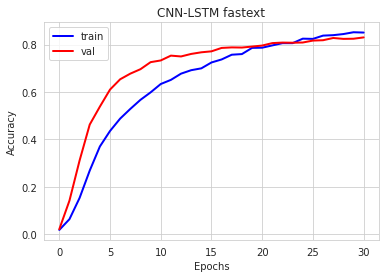

In [34]:
plt.figure()
plt.plot(history.history['accuracy'], lw=2.0, color='b', label='train')
plt.plot(history.history['val_accuracy'], lw=2.0, color='r', label='val')
plt.title('CNN-LSTM fastext')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='upper left')
plt.show()

In [35]:
predictions = model_cnn_ft.predict(word_seq_test)
list_ = []
for i in range(len(predictions)):
  a = predictions[i]
  list_.append(np.where(a == a.max())[0][0] )


sample= test_df
sample['pred']= list_ 
sample[['pred', "l"]]

,pred,l
6113,22,22
2453,23,23
2442,49,49
2859,66,47
12994,69,69
...,...,...
7532,27,27
3434,57,15
694,17,17
5168,68,68


In [36]:
import sklearn

print("Accuracy With fastText CNN-LSTM :")
print(sklearn.metrics.accuracy_score(sample.l, sample.pred))

Accuracy With fastText CNN-LSTM :
0.816679188580015
